In [47]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10, mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
# SKLearn for classification quality analysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

np.random.seed(0)
! pip list | grep tensorflow

tensorflow                         2.0.0              
tensorflow-estimator               2.0.1              


In [36]:
#suppress unwanted outputs
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

Load in MNIST Data

In [37]:
%%time
(x_train, y_train), (x_test, y_test) = mnist.load_data()

CPU times: user 224 ms, sys: 22.4 ms, total: 247 ms
Wall time: 249 ms


In [38]:
s1 = x_train.shape
s2 = x_test.shape
print(f"The mnist data was loaded with {s1[0]} training samples and {s2[0]} testing samples. Each sample is a {s1[1]} x {s1[2]} pixel image.")

The mnist data was loaded with 60000 training samples and 10000 testing samples. Each sample is a 28 x 28 pixel image.


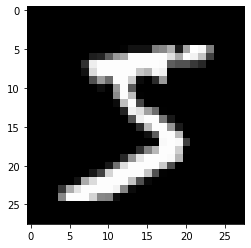

In [39]:
example = x_train[0]
plt.imshow(example, cmap="gray", vmin=0, vmax=255)

In [40]:
def calculate_conv_shape(X, K, padding=0, stride=1):
    """Calculate the shape of the output of a convolution 
    
    Args:
        X (np.array): The input matrix
        K (np.array): The filter matrix
        padding (int, optional): Defaults to 0. The padding dimension
        stride (int, optional): Defaults to 1. The stride of the convolution
    
    Returns:
        tuple: The shape of the convolution output (height followed by width)
    """
    # YOUR CODE HERE
    xw=X.shape[1]
    xh=X.shape[0]
    kw=K.shape[1]
    kh=K.shape[0]
    yw=int(((xw-kw+2*padding)/stride)+1)
    yh=int(((xh-kh+2*padding)/stride)+1)
    return yh, yw

Create simple CNN

In [41]:
simple_layers=[Flatten(),
               Dense(200, activation='relu', input_shape=(784,)),
               Dropout(.1),
               Dense(200, activation='relu'),
               Dropout(.05),
               Dense(10, activation='softmax'),
               ]
simple_model = keras.Sequential(simple_layers)


simple_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
simple_model.fit(x_train, y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 58us/sample - loss: 1.8976 - accuracy: 0.8451
Epoch 2/5
60000/60000 [==============================] - 3s 51us/sample - loss: 0.4301 - accuracy: 0.9031
Epoch 3/5
60000/60000 [==============================] - 3s 50us/sample - loss: 0.2803 - accuracy: 0.9288
Epoch 4/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.2217 - accuracy: 0.9407
Epoch 5/5
60000/60000 [==============================] - 4s 70us/sample - loss: 0.1997 - accuracy: 0.9467


In [42]:
with suppress_stdout():
    simple_scores = simple_model.evaluate(x_test, y_test)
print(f"\nThe simple model achieves an accuracy of {simple_scores[1]*100:.2f}% on the test data with only 5 epochs.")


The simple model achieves an accuracy of 96.11% on the test data with only 5 epochs.


Looking into prediction with the model with Confusion Matrix.

In [49]:
predictions = simple_model.predict(x_test)
# For each of the 10000 test images, you get 10 values (from the softmax 10 layer)
predictions.shape

(10000, 10)

In [72]:
class_names=list(range(1,11))
class_names=['1','2','3','4','5','6','7','8','9','0']

In [75]:

y_pred = np.argmax(predictions, axis=1)
conf = confusion_matrix(y_test, y_pred) #args are (true labels, predicted labels)
classif_rep = classification_report(y_test, y_pred, target_names=class_names) #args are (true labels, predicted labels, label strings)

print('Confusion Matrix - Predicted on X, Truth on Y')

print(conf)

print('Classification Report')
print('Precision_i = M_ii / Sum_j M_ji : Proportion of observations predicted i that actually are i')
print('Recall_i = M_ii / Sum_j M_ij : Proportion of observations that actually are i predicted i')
print('f-1_i = mean(Precision_i, Recall_i) : Equal weight average of precision and recall for class i')
print('support_i = Sum_j M_ij : Total observations in validation set that are truly class i')

print(classif_rep)

print('micro_avg_j = Global average by counting the total true positives, false negatives and false positives.')
print('macro_avg_j = Average across classes (ignores class size imbalance).')
print('weighted_avg_j = Calculate metrics for each label, and find their average weighted by support.')

Confusion Matrix - Predicted on X, Truth on Y
[[ 965    0    3    2    0    1    2    3    4    0]
 [   0 1127    2    1    1    0    2    0    2    0]
 [   6    3  989   14    2    1    4    5    7    1]
 [   0    2    5  985    1    6    0    4    2    5]
 [   1    1    3    0  954    0   10    1    1   11]
 [   4    0    3   22    3  836    6    3   10    5]
 [  10    3    1    0    8    5  926    0    4    1]
 [   2    8   15    4    4    0    0  980    1   14]
 [   5    6    5   15   18    5    6    3  905    6]
 [   5    6    1   16   18    1    1   13    4  944]]
Classification Report
Precision_i = M_ii / Sum_j M_ji : Proportion of observations predicted i that actually are i
Recall_i = M_ii / Sum_j M_ij : Proportion of observations that actually are i predicted i
f-1_i = mean(Precision_i, Recall_i) : Equal weight average of precision and recall for class i
support_i = Sum_j M_ij : Total observations in validation set that are truly class i
              precision    recall  f1-

In [79]:
## Fancier Confusion matrix plotting
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          fig_size = (11,11)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 965    0    3    2    0    1    2    3    4    0]
 [   0 1127    2    1    1    0    2    0    2    0]
 [   6    3  989   14    2    1    4    5    7    1]
 [   0    2    5  985    1    6    0    4    2    5]
 [   1    1    3    0  954    0   10    1    1   11]
 [   4    0    3   22    3  836    6    3   10    5]
 [  10    3    1    0    8    5  926    0    4    1]
 [   2    8   15    4    4    0    0  980    1   14]
 [   5    6    5   15   18    5    6    3  905    6]
 [   5    6    1   16   18    1    1   13    4  944]]


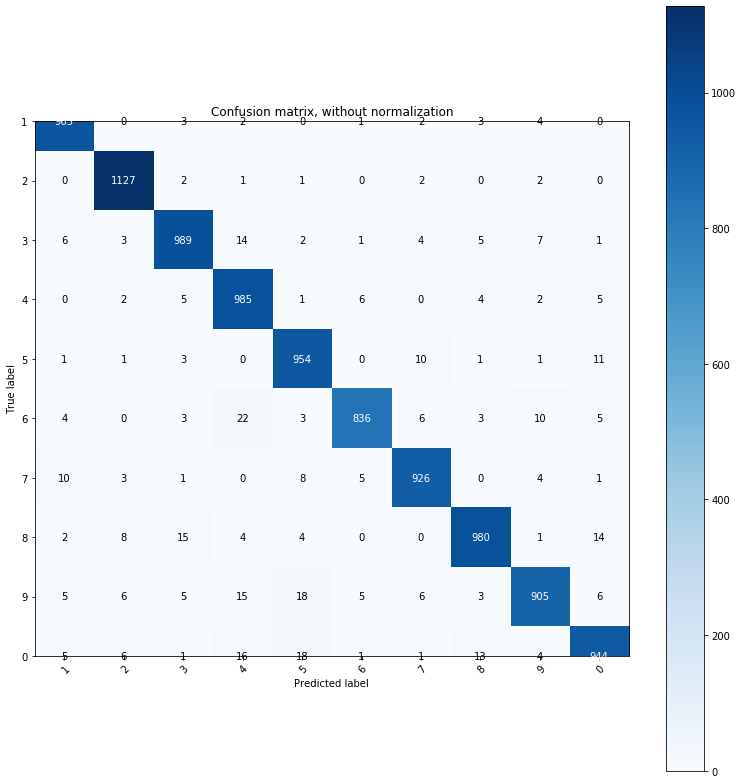

In [83]:
plot_confusion_matrix(y_test, y_pred,class_names,fig_size = (11,11))

Now we'll create a CNN and see how it compares to our regular CNN. We'll use Conv2D for the convolutional layers and MaxPool2D for pooling.

For the convolutional layers below, use a 3*3 convolutional filter and be sure to set the padding.

In [19]:
cnn_layers=[Conv2D(32,kernel_size=(3,3), strides=(1,1), padding='same',activation='relu', input_shape=(28,28,1)),
          MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same'),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Flatten(),
           Dense(200, activation='relu'),
           Dense(200, activation='relu'),
           Dense(10, activation='softmax')]

cnn_model=keras.Sequential(cnn_layers)

cnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(x_train.reshape(-1, 28, 28 ,1), y_train, epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 41s 690us/sample - loss: 0.2386 - accuracy: 0.9461
Epoch 2/3
60000/60000 [==============================] - 42s 705us/sample - loss: 0.0749 - accuracy: 0.9781
Epoch 3/3
60000/60000 [==============================] - 44s 735us/sample - loss: 0.0717 - accuracy: 0.9799


In [24]:
with suppress_stdout():
    cnn_scores = cnn_model.evaluate(x_test.reshape(-1, 28, 28 ,1), y_test)
print(f"\nThe CNN model achieves an accuracy of {cnn_scores[1]*100:.2f}% on the test data.")


The CNN model achieves an accuracy of 98.25% on the test data.


Testing using Dropout in the model.

In [27]:
cnn_dropout_layers=[Conv2D(32,kernel_size=(3,3), strides=(1,1), padding='same',activation='relu', input_shape=(28,28,1)),
          MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same'),
            Dropout(.5),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
            Dropout(.5),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
            Dropout(.5),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Flatten(),
           Dense(200, activation='relu'),
           Dense(200, activation='relu'),
           Dense(10, activation='softmax')]

cnn_model_dropout=keras.Sequential(cnn_dropout_layers)

cnn_model_dropout.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_dropout.fit(x_train.reshape(-1, 28, 28 ,1), y_train, epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 45s 745us/sample - loss: 0.7002 - accuracy: 0.7972
Epoch 2/3
60000/60000 [==============================] - 48s 797us/sample - loss: 0.2033 - accuracy: 0.9402
Epoch 3/3
60000/60000 [==============================] - 51s 850us/sample - loss: 0.1663 - accuracy: 0.9531


In [28]:
with suppress_stdout():
    cnn_scores = cnn_model_dropout.evaluate(x_test.reshape(-1, 28, 28 ,1), y_test)
print(f"\nThe CNN model with .5 dropout achieves an accuracy of {cnn_scores[1]*100:.2f}% on the test data.")


The CNN model with .5 dropout achieves an accuracy of 96.00% on the test data.


In [29]:
cnn_dropout_layers=[Conv2D(32,kernel_size=(3,3), strides=(1,1), padding='same',activation='relu', input_shape=(28,28,1)),
          MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same'),
            Dropout(.2),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
            Dropout(.2),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
            Dropout(.2),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Flatten(),
           Dense(200, activation='relu'),
           Dense(200, activation='relu'),
           Dense(10, activation='softmax')]

cnn_model_dropout=keras.Sequential(cnn_dropout_layers)

cnn_model_dropout.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_dropout.fit(x_train.reshape(-1, 28, 28 ,1), y_train, epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 53s 879us/sample - loss: 0.3088 - accuracy: 0.9176
Epoch 2/3
60000/60000 [==============================] - 57s 952us/sample - loss: 0.1009 - accuracy: 0.9705
Epoch 3/3
60000/60000 [==============================] - 56s 933us/sample - loss: 0.0903 - accuracy: 0.9741


In [30]:
with suppress_stdout():
    cnn_scores = cnn_model_dropout.evaluate(x_test.reshape(-1, 28, 28 ,1), y_test)
print(f"\nThe CNN model with .2 dropout achieves an accuracy of {cnn_scores[1]*100:.2f}% on the test data.")


The CNN model with .2 dropout achieves an accuracy of 97.83% on the test data.
